In [1]:
#import library
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
n_arms = 4
class Env(object):
    thetas = [0.1,0.1,0.2,0.3]
    
    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0
    
    def opt():
        return np.argmax(Env.thetas)

In [3]:
class EpsilonGreedyAgent(object):
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] +=1
        self.values[arm] = (
            (self.counts[arm] -1) * self.values[arm] + reward) / self.counts[arm]

In [4]:
class AnnealingEpsilonGreedAgent(object):
    
    def __init__(self, epsilon = 1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] -1) * self.values[arm] + reward) / self.counts[arm]

In [5]:
class SoftmaxAgent(object):
    def __init__(self,  tau =.05):
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        return p
    
    def get_arm(self):
        arm = np.random.choice(n_arms, p = self.softmax_p())
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] -1) * self.values[arm] + reward) / self.counts[arm]
    

In [6]:
class AnnealingSoftmaxAgent(object):
    
    def __init__(self, tau = 1000.):
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        return p
    
    def get_arm(self):
        arm = np.random.choice(n_arms,  p = self.softmax_p())
        self.tau = self.tau * 0.9
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] -1) * self.values[arm] + reward) / self.counts[arm]

In [7]:
class BernoulliTSAgent(object):
    
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)]
        
    def get_arm(self):
        beta = lambda N, a : np.random.beta(a+1, N-a+1)
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] = self.counts[arm] +1
        self.wins[arm] = self.wins[arm] + reward

In [8]:
def sim(Agent, N = 1000, T = 1000, **kwargs):
    selected_arms = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]
    
    for n in range(N):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arms[n][t] = arm
            earned_rewards[n][t] = reward
    return np.array(selected_arms), np.array(earned_rewards)

In [9]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)

In [10]:
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedAgent)

In [11]:
arms_sm, rewards_sm  = sim(SoftmaxAgent)

In [12]:
arms_asm, rewards_asm = sim(AnnealingSoftmaxAgent)

In [13]:
arms_ts, reward_ts = sim(BernoulliTSAgent)

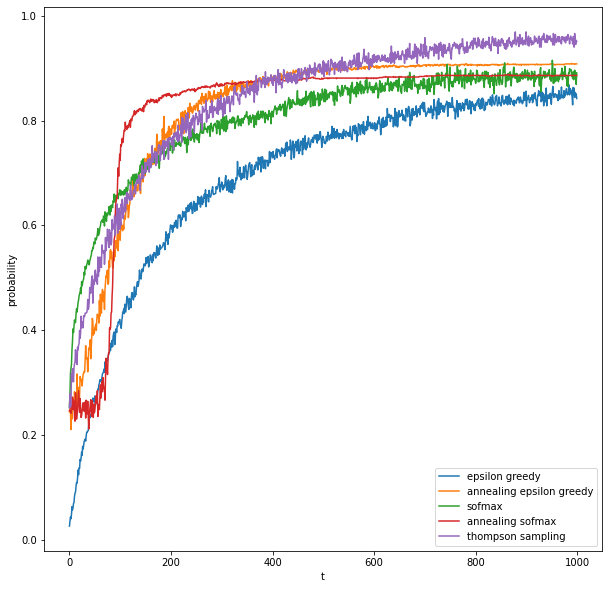

In [14]:
# visualization
plt.figure(figsize = (10,10))
plt.plot(np.mean(arms_eg == Env.opt(), axis = 0), label = 'epsilon greedy')
plt.plot(np.mean(arms_aeg == Env.opt(), axis = 0), label = 'annealing epsilon greedy')
plt.plot(np.mean(arms_sm == Env.opt(), axis = 0), label = 'sofmax')
plt.plot(np.mean(arms_asm == Env.opt(), axis = 0), label = 'annealing sofmax')
plt.plot(np.mean(arms_ts == Env.opt(), axis = 0), label = 'thompson sampling')
plt.xlabel('t')
plt.ylabel('probability')
plt.legend()
plt.show()

In [15]:
arms_ts

array([[3, 3, 0, ..., 3, 3, 3],
       [0, 1, 3, ..., 3, 3, 3],
       [2, 1, 1, ..., 2, 3, 3],
       ...,
       [1, 1, 3, ..., 3, 3, 3],
       [1, 0, 3, ..., 3, 3, 3],
       [0, 1, 3, ..., 2, 3, 3]])

In [16]:
arms_sm

array([[2, 2, 2, ..., 3, 3, 3],
       [1, 0, 1, ..., 1, 3, 3],
       [2, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 2, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [1, 2, 3, ..., 3, 1, 3]])

In [17]:
rewards_sm

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])